In [1]:
from IPython.display import clear_output, display, HTML
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from pathlib import Path
from sklearn.decomposition import PCA
from numpy.fft import fft, rfft
from scipy.signal import spectrogram
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize
import warnings
from scipy.ndimage import gaussian_filter1d
import random
from wfOpto import *
warnings.filterwarnings("ignore")
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
#work
plt.style.use(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\ALpres.mplstyle')

In [3]:
dataVis19 = wfOpto(Path(r'Y:\Subjects\AL_0035\2025-01-19\1'))

In [16]:
dataVis8 = wfOpto(Path(r'Y:\Subjects\AL_0035\2025-01-08\1'))

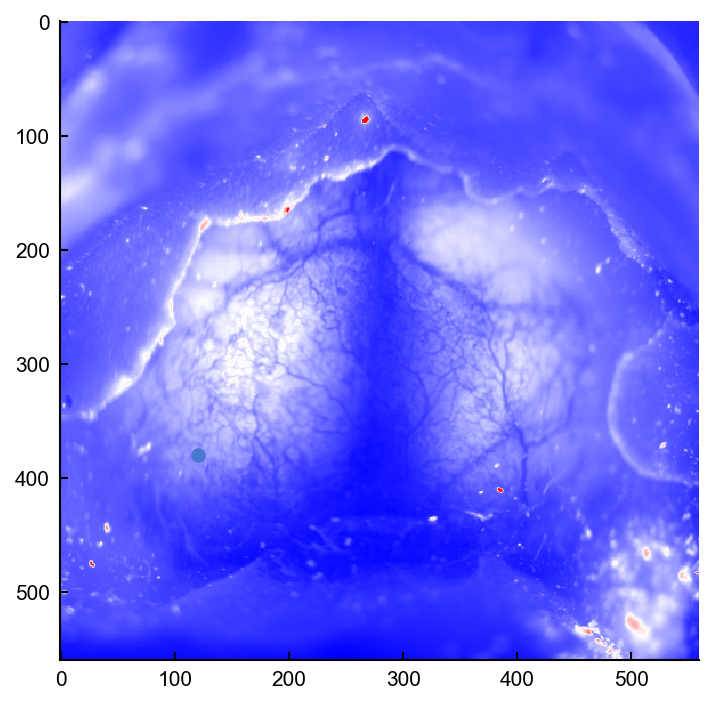

In [4]:
plt.imshow(dataVis19.meanImage, cmap='bwr')
plt.scatter(x=120,y=380)

if one takes the mean as the baseline of a trial, the (mean-baseline)/(mean) should by definition go to zero 

# one trial test with baseline dF/F
- did not re-add mean

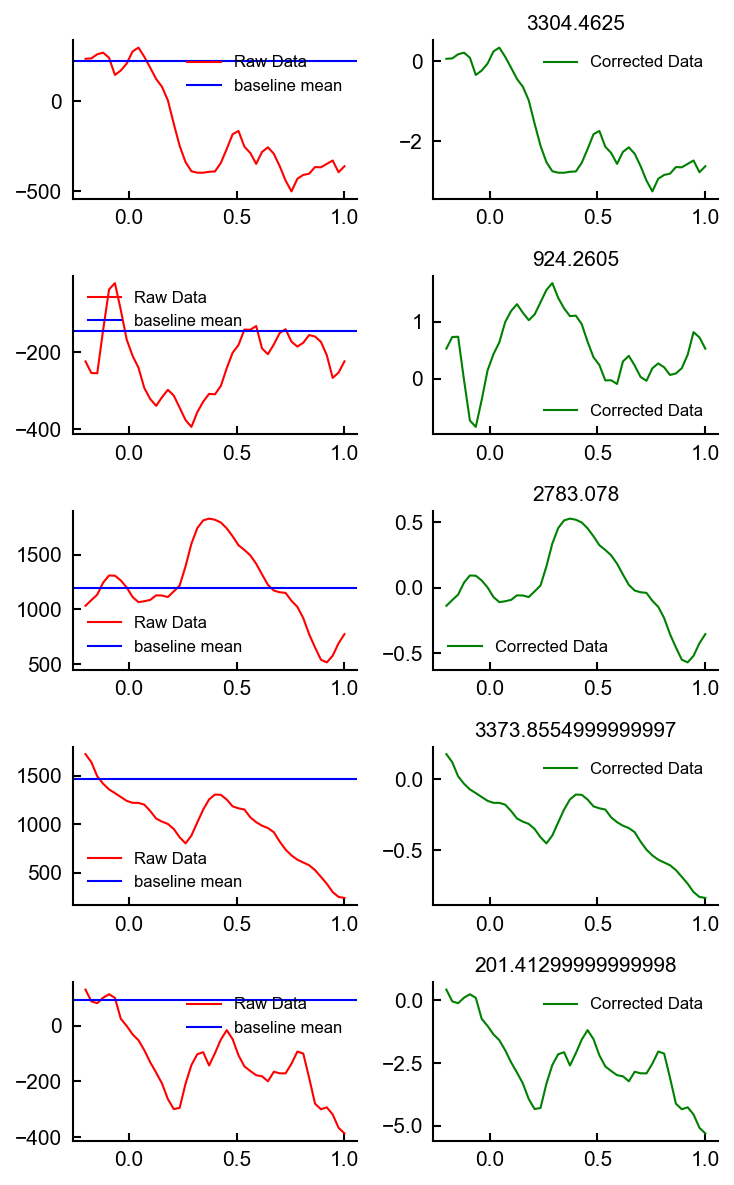

In [200]:
fig = plt.figure(figsize=(5,8))
gs = mpl.gridspec.GridSpec(5, 2, width_ratios=[1, 1])
for i in range(5):
    trial = dataVis19.laserOn[random.randint(0, len(dataVis19.laserOn)-1)] #find the starting time of some random trial
    time = np.linspace(-.1+trial, 1+trial, 45) #get the timestamps for that trial from -.2:1s with 45 samples
    temporal_components = dataVis19.tToWFManual(time) #get the temporal components for that trial
    pixel_ix = np.ravel_multi_index((380,120), (dataVis19.py, dataVis19.px))
    spatial_components = dataVis19.svdSpat[pixel_ix] #get the spatial components for a pixel in the visual cortex
    neural_activity = spatial_components @ temporal_components.T #get the neural activity for that trial

    #find the mean during the baseline period
    baseline_mean = np.mean(neural_activity[0:7]) #7 samples bc 0.2s*35hz = 10 samples

    #df/f
    neural_activity_corrected = (neural_activity - baseline_mean) / baseline_mean

    ax1 = fig.add_subplot(gs[i, 0])
    ax1.plot(np.linspace(-.2,1,45),neural_activity,label='Raw Data',color='r')
    ax1.axhline(baseline_mean, color='b',label='baseline mean')
    ax1.legend()
    ax2 = fig.add_subplot(gs[i, 1])
    ax2.plot(np.linspace(-.2,1,45),neural_activity_corrected,label='Corrected Data',color='g')
    ax2.set_title(trial)
    ax2.legend()

## random trial test

In [280]:
galvoY=np.argwhere(dataVis19.galvoY[1081:]==0)
power=np.argwhere(dataVis19.laserPowers[1081:]==3)
trs = np.intersect1d(galvoY,power)

adapt = dataVis19.laserOn[trs]
sampled_trials = np.random.choice(adapt, 5, replace=False)

corrected=[]
raw=[]
for tr in sampled_trials:
    time = np.linspace(-.2+tr, 1+tr, 45) #get the timestamps for that trial from -.2:1s with 45 samples
    temporal_components = dataVis19.tToWFManual(time) #get the temporal components for that trial
    spatial_components = dataVis19.svdSpat[pixel_ix] #get the spatial components for a pixel in the visual cortex
    neural_activity = spatial_components @ temporal_components.T #get the neural activity for that trial
    neural_activity = np.abs(neural_activity)
    baseline_mean = np.mean(neural_activity[0:7]) #7 samples bc 0.2s*35hz = 7 samples
    neural_activity_corrected = (neural_activity - baseline_mean) / baseline_mean

    raw.append(neural_activity)
    corrected.append(neural_activity_corrected)
corrected=np.array(corrected)
raw=np.array(raw)
    

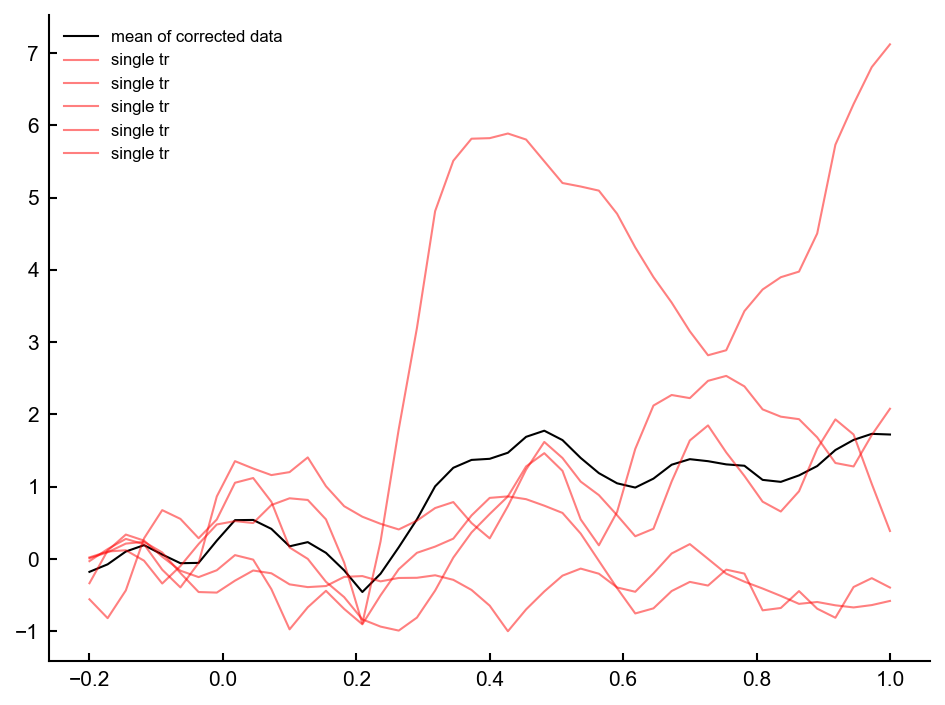

In [281]:
plt.plot(np.linspace(-.2,1,45),np.mean(corrected,axis=0),color='k',label='mean of corrected data')
for iC,corr in enumerate(corrected):
    plt.plot(np.linspace(-.2,1,45),corr,color='r',alpha=0.5,label='single tr')
plt.legend()
plt.show()

## multiple power test

In [294]:
corrected_allpowers=[]
for iP, power in enumerate(np.unique(dataVis19.laserPowers)):
    galvoY=np.argwhere(dataVis19.galvoY[:1081]==0)
    power=np.argwhere(dataVis19.laserPowers[:1081]==power)
    trs = np.intersect1d(galvoY,power)

    adapt = dataVis19.laserOn[trs]

    corrected=[]

    for tr in adapt:
        time = np.linspace(-.2+tr, 1+tr, 45) #get the timestamps for that trial from -.2:1s with 45 samples
        temporal_components = dataVis19.tToWFManual(time) #get the temporal components for that trial
        spatial_components = dataVis19.svdSpat[pixel_ix] #get the spatial components for a pixel in the visual cortex
        neural_activity = spatial_components @ temporal_components.T #get the neural activity for that trial
        neural_activity = neural_activity + np.abs(np.min(neural_activity))
        baseline_mean = np.mean(neural_activity[0:7]) #7 samples bc 0.2s*35hz = 7 samples
        neural_activity_corrected = (neural_activity - baseline_mean) / baseline_mean

        corrected.append(neural_activity_corrected)

    corrected_allpowers.append(np.mean(corrected,axis=0))

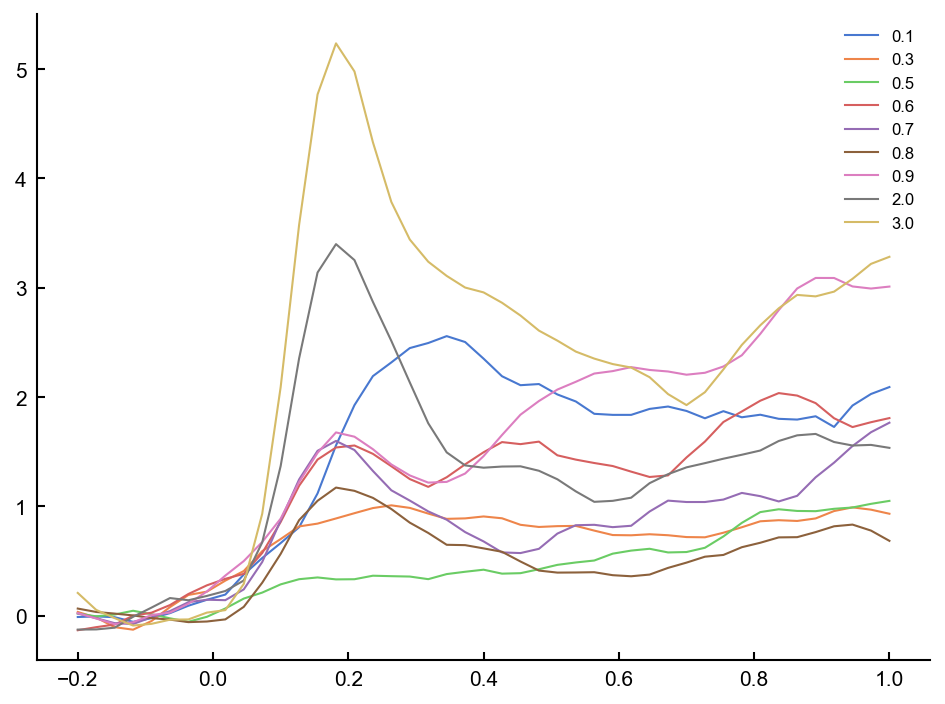

In [295]:
for c in corrected_allpowers:
    plt.plot(np.linspace(-.2,1,45),c)
plt.legend(np.unique(dataVis19.laserPowers))

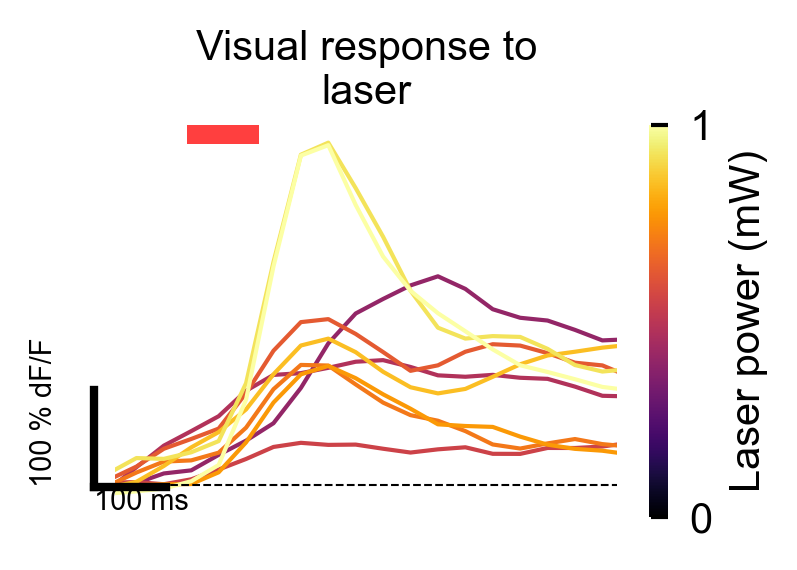

In [348]:
data=dataVis19
powers=np.unique(data.laserPowers)
galvoX=0;galvoY=0;x=120;y=380;width=1;anchor=(1,1)
ylim=[-0.01,0.008];start=-0.3;end=1;xlim=[-0.01,0.5]
t=1080
n_samples = round(start*-1+end)*35
colors=plt.cm.inferno(np.linspace(.4,1,len(powers)))
pxPowers = []
sems=[]
timestamps = np.linspace(start, end, n_samples)
galvoXTr=np.argwhere(data.galvoX[:t]==galvoX).ravel()
galvoYTr=np.argwhere(data.galvoY[:t]==galvoY).ravel()
loc=np.intersect1d(galvoXTr,galvoYTr)

y_range = np.arange(y - width, y + width)
x_range = np.arange(x - width, x + width)
# Create a meshgrid of the coordinates
y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
# Flatten the coordinate arrays
y_coords_flat = y_coords.flatten()
x_coords_flat = x_coords.flatten()
# Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

for power in powers:
    pwTrs = np.argwhere(data.laserPowers[:t]== power).ravel()
    theseTrs=np.intersect1d(pwTrs,loc)
    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))

    trial_activity=[]
    for trial in trs:
        wf = data.tToWFManual(trial)
        mov = data.svdSpat[flat_indices] @ wf.T
        mov_area_avg = np.mean(mov,axis=0) #avg over the 900 pixels
        mov_abs = mov_area_avg + np.abs(np.min(mov_area_avg))
        baseline_mean = np.mean(mov_abs[0:7])
        dff = (mov_abs - baseline_mean) / baseline_mean
        trial_activity.append(dff)
    pxPowers.append(np.mean(trial_activity,axis=0))
    sems.append(scipy.stats.sem(trial_activity,axis=0))

fig=plt.figure(figsize=(5,2),dpi=300)
gs = mpl.gridspec.GridSpec(1,2, figure=fig)
width_ratios = [1,1]
powerscorr = [round(i/2.777777778,2) for i in powers]
ax = plt.subplot(gs[0,0])
lines = [plt.plot(timestamps, y, label=f'{powerscorr[i]} mW',color=colors[i])[0] for i, y in enumerate(pxPowers)]

# for iP, power in enumerate(pxPowers):
#     plt.fill_between(timestamps, \
#             power-sems[iP],\
#             power+sems[iP], color=colors[iP],label='_nolegend_',alpha=.5,linewidth=0)

plt.axvspan(0,.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)

#set colorbar
cm = mpl.cm.ScalarMappable(cmap='inferno') # creates a color mapping object
cm.set_clim(0, 1) # sets limits to our power mW limits - exp.v_to_mw is 2.7 here
# plt.plot(x, y, c=cm.to_rgba(power/2.7), label=f'{power/2.7} mW') # the power variable is in V (taken from data npys)
cbar = plt.colorbar(ax=ax,mappable=cm,label='Laser power (mW)') # tells the colorbar to use your colormap object
cbar.set_ticks([0,1])
cbar.outline.set_visible(False)

#make scale bars
t_bar_s = 0.1 # length of time bar
dff_bar = 1 # length of dff bar
x_start = 0 - 0.13 # where the bar should start
y_start = -0.016 # where the bar should start

# plt.ylim([-.01,.03])
plt.xlim([-.1,0.6])
plt.axhline(0, color='k', linestyle='--',lw=0.5)
plt.plot([x_start, x_start+t_bar_s], [y_start, y_start], c='k', lw=2, clip_on=False) # these plot the bars
plt.plot([x_start, x_start], [y_start, y_start+dff_bar], c='k', lw=2, clip_on=False)
plt.text(x_start, y_start-0.01, f'{t_bar_s*1000:.0f} ms', ha='left', va='top', fontsize='x-small') # these are the text
plt.text(x_start-0.05, y_start, f'{dff_bar*100:.0f} % dF/F', ha='right', va='bottom', rotation=90, fontsize='x-small')
plt.title(f'Visual response to\nlaser')
plt.axvspan(0,0.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])
# fig.savefig('C:/Users/nadia/Documents/GitHub/steinmetzlab/wf + opto/log figs/AL35_119_new.png',dpi=300)

## comparing adapt to not

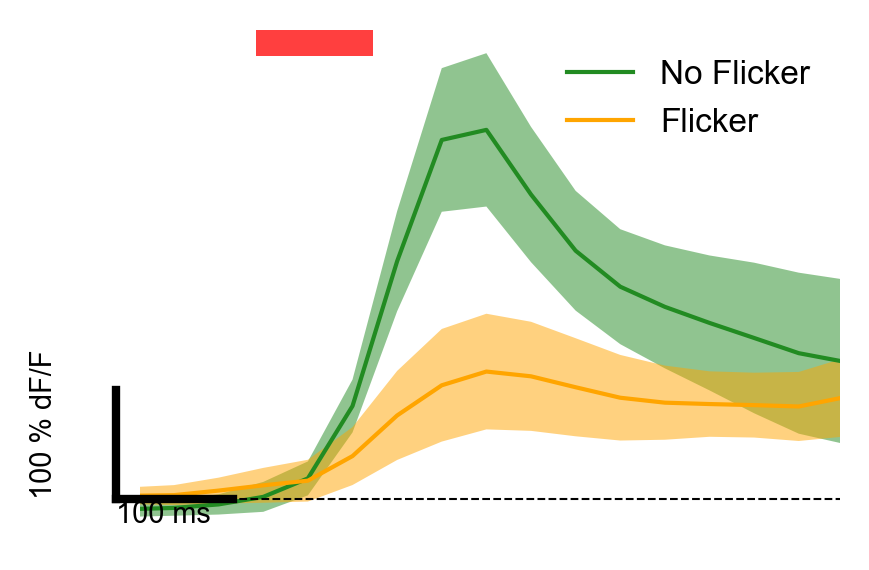

In [317]:
def visRespCompare(ax,data,exptrs=np.array([0,1080,2160]),power=3,start=-.3,end=1,\
                   galvoX=0,galvoY=0,x=120,y=380,width=15,title="Response in VisP",\
                   labels=['No Flicker','Flicker'],legend=True):
    '''
    trace of response in VC compared with and without flicker 
    '''
    xTrace = []
    sems=[]
    colors=['forestgreen','orange']
    labels=['No Flicker','Flicker']
    n_samples=round(start*-1+end)*35
    timestamps = np.linspace(start, end, n_samples)

    meanimg = data.meanImage.reshape(560,560,-1)
    avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))
    
    for i in range(2):
        tr1 = exptrs[i]
        tr2 = exptrs[i+1]
        pwTrs = np.argwhere(data.laserPowers[tr1:tr2] == power).ravel()
        galvoXTrs=np.argwhere(data.galvoX[tr1:tr2]==galvoX).ravel()
        galvoYTrs=np.argwhere(data.galvoY[tr1:tr2]==galvoY).ravel()
        loc=np.intersect1d(galvoXTrs,galvoYTrs)
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        trial_activity=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            mov_area_avg = np.mean(mov,axis=0) #avg over the 900 pixels
            mov_abs = mov_area_avg + np.abs(np.min(mov_area_avg))
            baseline_mean = np.mean(mov_abs[0:7])
            dff = (mov_abs - baseline_mean) / baseline_mean
            trial_activity.append(dff)
        sems.append(scipy.stats.sem(trial_activity,axis=0))
        xTrace.append(np.mean(trial_activity,axis=0))

    for iP, trace in enumerate(xTrace):
        plt.plot(timestamps,trace, label=labels[iP], color=colors[iP])
        plt.fill_between(timestamps, \
                trace-sems[iP],\
                trace+sems[iP], color=colors[iP],label='_nolegend_',alpha=.5,linewidth=0)
    plt.axvspan(0,.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)
    plt.axhline(0, c='k',lw=0.5, ls='--')
    #make scale bars
    t_bar_s = 0.1 # length of time bar
    dff_bar = 1 # length of dff bar
    x_start = 0 - 0.12 # where the bar should start
    y_start = -0.006 # where the bar should start
    plt.legend()
    plt.xlim([-0.1,0.5])
    plt.plot([x_start, x_start+t_bar_s], [y_start, y_start], c='k', lw=2, clip_on=False) # these plot the bars
    plt.plot([x_start, x_start], [y_start, y_start+dff_bar], c='k', lw=2, clip_on=False)
    plt.text(x_start, y_start-0.01, f'{t_bar_s*1000:.0f} ms', ha='left', va='top', fontsize='x-small') # these are the text
    plt.text(x_start-0.05, y_start, f'{dff_bar*100:.0f} % dF/F', ha='right', va='bottom', rotation=90, fontsize='x-small')
    plt.axvspan(0,0.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.xticks([])
    plt.yticks([])
fig,ax=plt.subplots(figsize=(3,2),dpi=300)
visRespCompare(ax,dataVis19,x=120,y=380)


## across powers adapt v not

In [324]:
def visrespcomparereturn(data,exptrs=[0,1080,2160],galvoX=0,galvoY=0,x=120,y=380,width=30,time=0.18,ylim=[-5,5],trialtake=35):
    # powers=[0.5,1,1.5,2,2.5]
    powers=np.unique(data.laserPowers)
    lenpws = len(powers)

    quantCompare = np.zeros((2,lenpws),dtype=float)
    semsCompare = np.zeros((2,lenpws),dtype=float)
    trial_peaks_saved = np.zeros((2,lenpws,trialtake))
    n_samples=round((0.3+1)*35)
    timestamps = np.linspace(-0.3, 1, n_samples)

    meanimg = data.meanImage.reshape(560,560,-1)
    avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

    noadapt_peaks_power=[]
    adapt_peaks_power=[]
    for i in range(2):
        pxPowers=[]
        sems=[]
        trial_peaks_power=[]
        tr1 = exptrs[i]
        tr2 = exptrs[i+1]
        galvoXTrs=np.argwhere(data.galvoX[tr1:tr2]==galvoX).ravel()
        galvoYTrs=np.argwhere(data.galvoY[tr1:tr2]==galvoY).ravel()
        loc=np.intersect1d(galvoXTrs,galvoYTrs)
        for iP, power in enumerate(powers):
            pwTrs = np.argwhere(data.laserPowers[tr1:tr2] == power).ravel()
            theseTrs=np.intersect1d(pwTrs,loc)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            trial_activity=[]
            trial_peaks=[]
            for trial in trs:
                wf = data.tToWFManual(trial)
                mov = data.svdSpat[flat_indices] @ wf.T
                mov_area_avg = np.mean(mov,axis=0) #avg over the 900 pixels
                mov_abs = mov_area_avg + np.abs(np.min(mov_area_avg))
                baseline_mean = np.mean(mov_abs[0:10])
                dff = (mov_abs - baseline_mean) / baseline_mean
                pixelInterpTrial = scipy.interpolate.interp1d(timestamps, dff, fill_value='extrapolate')
                trial_peaks.append(pixelInterpTrial(time))
            sems.append(scipy.stats.sem(trial_peaks,axis=0))
            pxPowers.append(np.mean(trial_peaks,axis=0))
            trial_peaks_power.append(trial_peaks[:trialtake])
        trial_peaks_saved[i]=trial_peaks_power
        quantCompare[i]=pxPowers
        semsCompare[i]=sems

    return quantCompare,semsCompare,trial_peaks_saved

In [343]:
quantCompare,semsCompare,trial_peaks=visrespcomparereturn(dataVis19,time=0.2)

Text(0.5, 0, 'Power (V)')

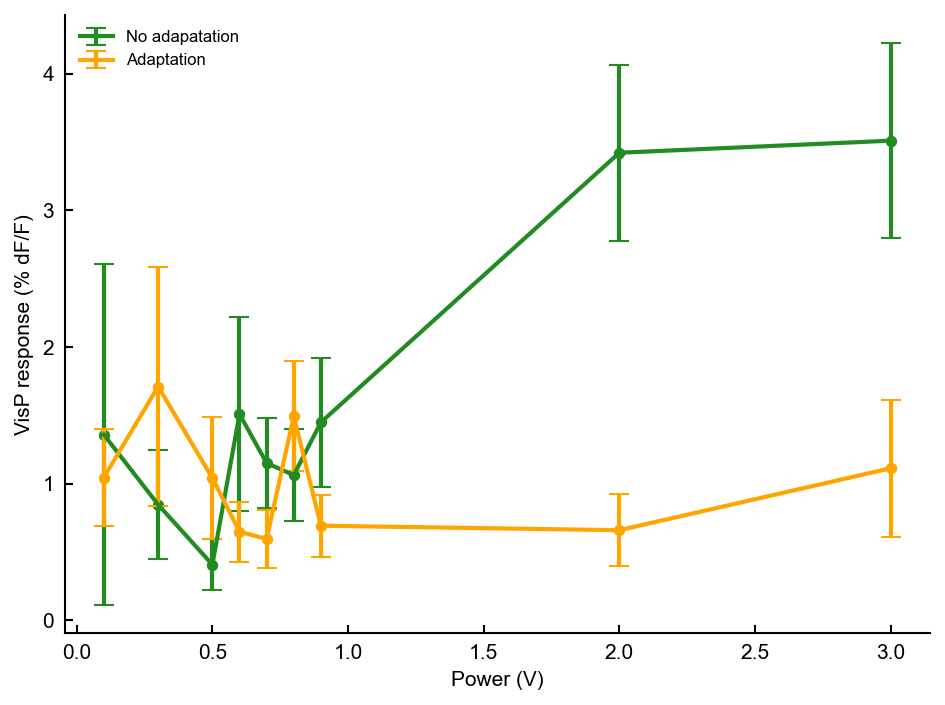

In [346]:
colors=['forestgreen','orange']
label=['No adapatation','Adaptation']
for i in range(2):
    # plt.plot(np.unique(dataVis19.laserPowers),quantCompare[i],label=label[i],color=colors[i],lw=2)
    plt.scatter(np.unique(dataVis19.laserPowers),quantCompare[i],color=colors[i],s=20)
    plt.errorbar(np.unique(dataVis19.laserPowers),quantCompare[i],yerr=semsCompare[i],color=colors[i],capsize=5,lw=2,label=label[i])
plt.legend()
plt.ylabel('VisP response (% dF/F)')
plt.xlabel('Power (V)')

## location comparison


In [312]:
def respQuantLocReturn(ax,data,galvoYList,powers,x=100,y=390,\
                 time=0.18,width=50,title='',ylim=[-0.1,0.04],t=600):
    '''
    plots 3 traces for 3 different locations to compare the activation of the visual cortex per location
    '''
    pxData=[]
    sems_final=[]
    trial_peaks_saved=[]
    labels=['Ant','Mid','Post']
    colors = plt.cm.Purples(np.linspace(.3,1,len(galvoYList)))
    start=0
    end=.5
    time=0.18
    n_samples = round((start+end)*35)
    timestamps = np.linspace(start, end, n_samples)

    meanimg = data.meanImage.reshape(560,560,-1)
    avg=meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

    for iD,yLoc in enumerate(galvoYList):
        pxPowers = []
        sems=[]
        locPeaks=[]
        galvoYTrs=np.argwhere(data.galvoY[:t]==yLoc).ravel()

        for iP, power in enumerate(powers):
            pwTrs = np.argwhere(data.laserPowers[:t] == power).ravel()
            theseTrs=np.intersect1d(pwTrs,galvoYTrs)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            trial_activity=[]
            trial_peaks=[]
            for trial in trs:
                wf = data.tToWFManual(trial)
                mov = data.svdSpat[flat_indices] @ wf.T
                mov_area_avg = np.mean(mov,axis=0) #avg over the 900 pixels
                mov_abs = mov_area_avg + np.abs(np.min(mov_area_avg))
                baseline_mean = np.mean(mov_abs[0:7])
                dff = (mov_abs - baseline_mean) / baseline_mean
                pixelInterpTrial = scipy.interpolate.interp1d(timestamps, dff, fill_value='extrapolate')
                trial_peaks.append(pixelInterpTrial(time))
                trial_activity.append(dff)
            sems.append(scipy.stats.sem(trial_peaks,axis=0))
            pxPowers.append(np.mean(trial_peaks,axis=0))
            locPeaks.append(trial_peaks)
        trial_peaks_saved.append(locPeaks)
        pxData.append(pxPowers)
        sems_final.append(sems)

    return pxData,sems_final,trial_peaks_saved

Text(0, 0.5, 'VISp % dF/F')

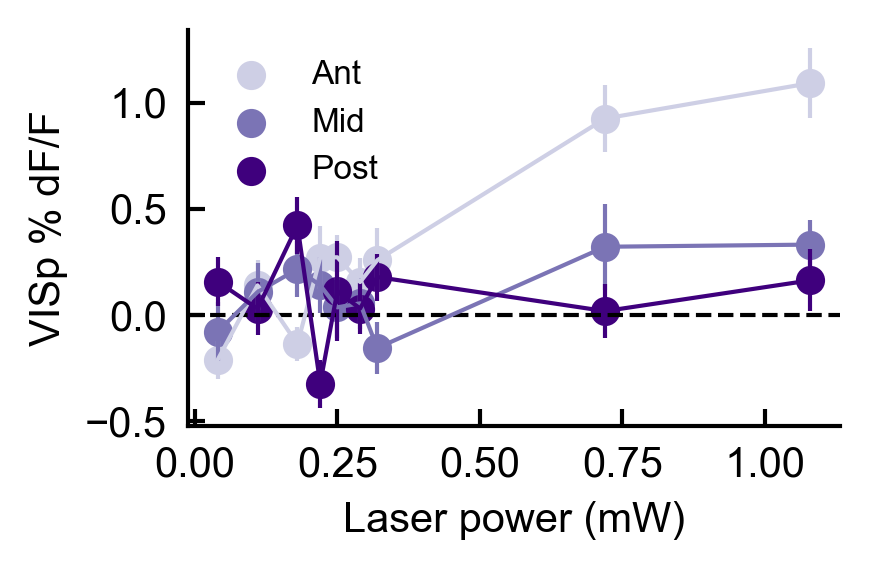

In [314]:
locAL35,semsLoc_AL35,trial_peaksAL35 = respQuantLocReturn(ax,dataVis19,[0,2,3],powers=np.unique(dataVis19.laserPowers),\
             x=120,y=415,time=0.18,width=15,title='',ylim=[-0.02,0.05],t=630)

fig,ax=plt.subplots(figsize=(3,2),dpi=300)
labels=['Ant','Mid','Post']
colors = plt.cm.Purples(np.linspace(.3,1,3))
powers=np.unique(dataVis19.laserPowers)
powers = [round(i/2.777777778,2) for i in powers]
for loc in range(3):
    plt.scatter(powers,locAL35[loc],color=colors[loc],label='_nolabel_')
    plt.errorbar(powers,locAL35[loc],yerr=semsLoc_AL35[loc],color=colors[loc])
plt.legend(labels)
plt.axhline(0,c='black',ls='--')
plt.xlabel("Laser power (mW)")
plt.ylabel(f'VISp % dF/F')

# base code

[25658.07072395] (1,)
40
40
40
40
40
40
40
40


([], [])

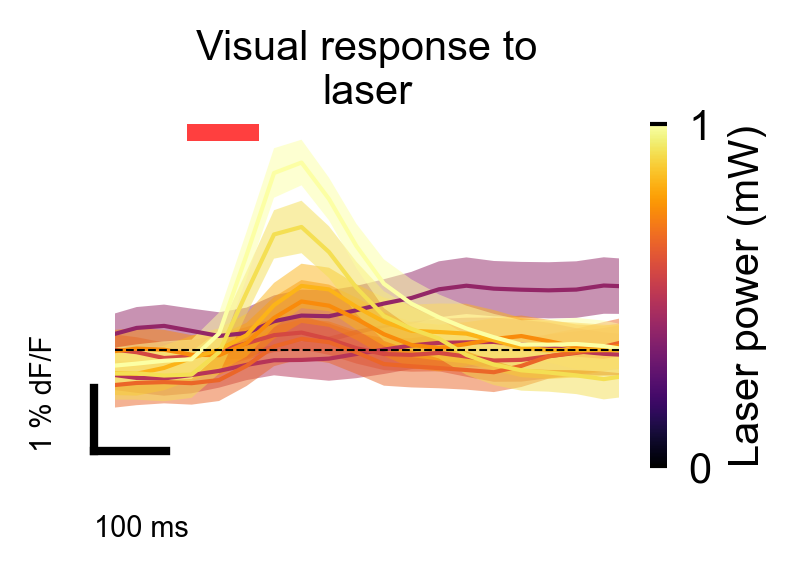

In [56]:
data=dataVis8
powers=np.unique(data.laserPowers)
galvoX=0;galvoY=0;x=120;y=380;width=15;anchor=(1,1)
ylim=[-0.01,0.008];start=-0.3;end=1;xlim=[-0.01,0.5]
t=960
n_samples = round(start*-1+end)*35
colors=plt.cm.inferno(np.linspace(.4,1,len(powers)))
pxPowers = []
sems=[]
timestamps = np.linspace(start, end, n_samples)
galvoXTr=np.argwhere(data.galvoX[:t]==galvoX).ravel()
galvoYTr=np.argwhere(data.galvoY[:t]==galvoY).ravel()
loc=np.intersect1d(galvoXTr,galvoYTr)

y_range = np.arange(y - width, y + width)
x_range = np.arange(x - width, x + width)
# Create a meshgrid of the coordinates
y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
# Flatten the coordinate arrays
y_coords_flat = y_coords.flatten()
x_coords_flat = x_coords.flatten()
# Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

#original
meanimg = data.meanImage.reshape(560,560,-1) #find the mean image of the entire dataset
avg = meanimg[(y-width):(y+width),(x-width):(x+width)] #find the average of the desired ROI
avg_meanim = np.mean(avg,axis=(0,1)) 
print(avg_meanim,avg_meanim.shape)

for power in powers:
    pwTrs = np.argwhere(data.laserPowers[:t]== power).ravel()
    theseTrs=np.intersect1d(pwTrs,loc)
    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    print(len(trs))

    trial_activity=[]
    for trial in trs:
        wf = data.tToWFManual(trial)
        mov = data.svdSpat[flat_indices] @ wf.T
        videoROI_avg = np.mean(mov,axis=0)
        dff = (videoROI_avg/avg_meanim)
        trial_activity.append(dff)
    pxPowers.append(np.mean(trial_activity,axis=0))
    sems.append(scipy.stats.sem(trial_activity,axis=0))

fig=plt.figure(figsize=(5,2),dpi=300)
gs = mpl.gridspec.GridSpec(1,2, figure=fig)
width_ratios = [1,1]
powerscorr = [round(i/2.777777778,2) for i in powers]
ax = plt.subplot(gs[0,0])
lines = [plt.plot(timestamps, y, label=f'{powerscorr[i]} mW',color=colors[i])[0] for i, y in enumerate(pxPowers)]

for iP, power in enumerate(pxPowers):
    plt.fill_between(timestamps, \
            power-sems[iP],\
            power+sems[iP], color=colors[iP],label='_nolegend_',alpha=.5,linewidth=0)

plt.axvspan(0,.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)

#set colorbar
cm = mpl.cm.ScalarMappable(cmap='inferno') # creates a color mapping object
cm.set_clim(0, 1) # sets limits to our power mW limits - exp.v_to_mw is 2.7 here
# plt.plot(x, y, c=cm.to_rgba(power/2.7), label=f'{power/2.7} mW') # the power variable is in V (taken from data npys)
cbar = plt.colorbar(ax=ax,mappable=cm,label='Laser power (mW)') # tells the colorbar to use your colormap object
cbar.set_ticks([0,1])
cbar.outline.set_visible(False)

#make scale bars
t_bar_s = 0.1 # length of time bar
dff_bar = 0.01 # length of dff bar
x_start = 0 - 0.13 # where the bar should start
y_start = -0.016 # where the bar should start

# plt.ylim([-.01,.03])
plt.xlim([-.1,0.6])
plt.axhline(0, color='k', linestyle='--',lw=0.5)
plt.plot([x_start, x_start+t_bar_s], [y_start, y_start], c='k', lw=2, clip_on=False) # these plot the bars
plt.plot([x_start, x_start], [y_start, y_start+dff_bar], c='k', lw=2, clip_on=False)
plt.text(x_start, y_start-0.01, f'{t_bar_s*1000:.0f} ms', ha='left', va='top', fontsize='x-small') # these are the text
plt.text(x_start-0.05, y_start, f'{dff_bar*100:.0f} % dF/F', ha='right', va='bottom', rotation=90, fontsize='x-small')
plt.title(f'Visual response to\nlaser')
plt.axvspan(0,0.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])
    



# ADDING BASELINE from trial and taking dF/F from whole session

[25658.07072395] (1,)


([], [])

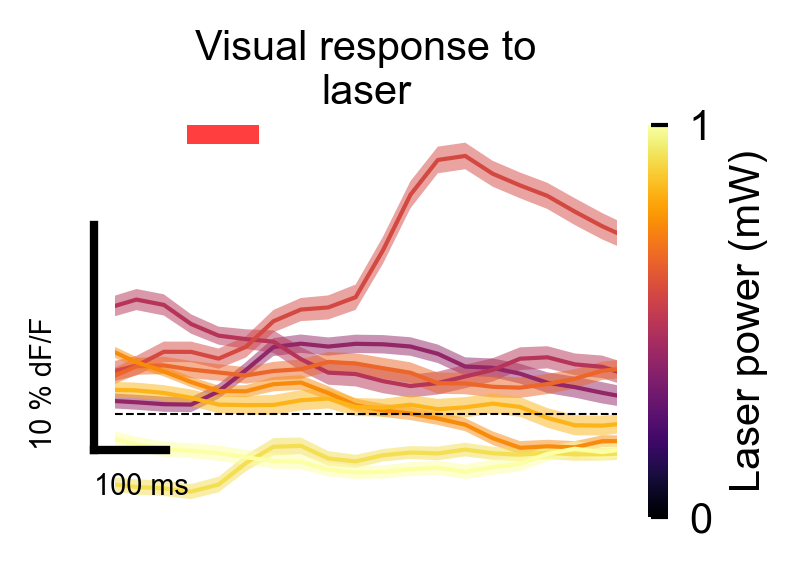

In [43]:
data=dataVis8
powers=np.unique(data.laserPowers)
galvoX=0;galvoY=0;x=120;y=380;width=15;anchor=(1,1)
ylim=[-0.01,0.008];start=-0.3;end=1;xlim=[-0.01,0.5]
t=1080
n_samples = round(start*-1+end)*35
colors=plt.cm.inferno(np.linspace(.4,1,len(powers)))
pxPowers = []
sems=[]
timestamps = np.linspace(start, end, n_samples)
galvoXTr=np.argwhere(data.galvoX[:t]==galvoX).ravel()
galvoYTr=np.argwhere(data.galvoY[:t]==galvoY).ravel()
loc=np.intersect1d(galvoXTr,galvoYTr)

y_range = np.arange(y - width, y + width)
x_range = np.arange(x - width, x + width)
# Create a meshgrid of the coordinates
y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
# Flatten the coordinate arrays
y_coords_flat = y_coords.flatten()
x_coords_flat = x_coords.flatten()
# Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

#original
meanimg = data.meanImage.reshape(560,560,-1) #find the mean image of the entire dataset
avg = meanimg[(y-width):(y+width),(x-width):(x+width)] #find the average of the desired ROI
avg_meanim = np.mean(avg,axis=(0,1)) 
print(avg_meanim,avg_meanim.shape)

for power in powers:
    pwTrs = np.argwhere(data.laserPowers[t:]== power).ravel()
    theseTrs=np.intersect1d(pwTrs,loc)
    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))

    trial_activity=[]
    for trial in trs:
        wf = data.tToWFManual(trial)
        mov = data.svdSpat[flat_indices] @ wf.T
        videoROI_avg = np.mean(mov,axis=0)
        dff = (videoROI_avg/avg_meanim)
        trial_activity.append(dff)
    mean_tr_ac = np.mean(trial_activity,axis=0) # take mean of all trials
    baseline = np.mean(mean_tr_ac[0:7]) # find what the baseline is around
    corrected_dff = mean_tr_ac - baseline # subtract the baseline to correct the activity to around zero
    pxPowers.append(dff)
    sems.append(scipy.stats.sem(trial_activity,axis=0))

fig=plt.figure(figsize=(5,2),dpi=300)
gs = mpl.gridspec.GridSpec(1,2, figure=fig)
width_ratios = [1,1]
powerscorr = [round(i/2.777777778,2) for i in powers]
ax = plt.subplot(gs[0,0])
lines = [plt.plot(timestamps, y, label=f'{powerscorr[i]} mW',color=colors[i])[0] for i, y in enumerate(pxPowers)]

for iP, power in enumerate(pxPowers):
    plt.fill_between(timestamps, \
            power-sems[iP],\
            power+sems[iP], color=colors[iP],label='_nolegend_',alpha=.5,linewidth=0)

plt.axvspan(0,.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)

#set colorbar
cm = mpl.cm.ScalarMappable(cmap='inferno') # creates a color mapping object
cm.set_clim(0, 1) # sets limits to our power mW limits - exp.v_to_mw is 2.7 here
# plt.plot(x, y, c=cm.to_rgba(power/2.7), label=f'{power/2.7} mW') # the power variable is in V (taken from data npys)
cbar = plt.colorbar(ax=ax,mappable=cm,label='Laser power (mW)') # tells the colorbar to use your colormap object
cbar.set_ticks([0,1])
cbar.outline.set_visible(False)

#make scale bars
t_bar_s = 0.1 # length of time bar
dff_bar = 0.1 # length of dff bar
x_start = 0 - 0.13 # where the bar should start
y_start = -0.016 # where the bar should start

# plt.ylim([-.01,.03])
plt.xlim([-.1,0.6])
plt.axhline(0, color='k', linestyle='--',lw=0.5)
plt.plot([x_start, x_start+t_bar_s], [y_start, y_start], c='k', lw=2, clip_on=False) # these plot the bars
plt.plot([x_start, x_start], [y_start, y_start+dff_bar], c='k', lw=2, clip_on=False)
plt.text(x_start, y_start-0.01, f'{t_bar_s*1000:.0f} ms', ha='left', va='top', fontsize='x-small') # these are the text
plt.text(x_start-0.05, y_start, f'{dff_bar*100:.0f} % dF/F', ha='right', va='bottom', rotation=90, fontsize='x-small')
plt.title(f'Visual response to\nlaser')
plt.axvspan(0,0.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])
    



# ADDING BASELINE but to each unique trial

[25658.07072395] (1,)


([], [])

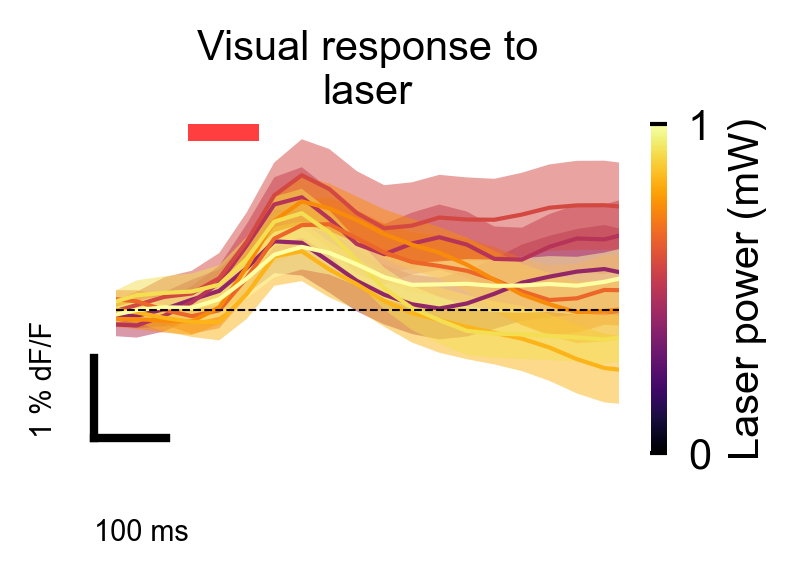

In [49]:
data=dataVis8
powers=np.unique(data.laserPowers)
galvoX=0;galvoY=0;x=120;y=380;width=15;anchor=(1,1)
ylim=[-0.01,0.008];start=-0.3;end=1;xlim=[-0.01,0.5]
t=1080
n_samples = round(start*-1+end)*35
colors=plt.cm.inferno(np.linspace(.4,1,len(powers)))
pxPowers = []
sems=[]
timestamps = np.linspace(start, end, n_samples)
galvoXTr=np.argwhere(data.galvoX[:t]==galvoX).ravel()
galvoYTr=np.argwhere(data.galvoY[:t]==galvoY).ravel()
loc=np.intersect1d(galvoXTr,galvoYTr)

y_range = np.arange(y - width, y + width)
x_range = np.arange(x - width, x + width)
# Create a meshgrid of the coordinates
y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
# Flatten the coordinate arrays
y_coords_flat = y_coords.flatten()
x_coords_flat = x_coords.flatten()
# Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

#original
meanimg = data.meanImage.reshape(560,560,-1) #find the mean image of the entire dataset
avg = meanimg[(y-width):(y+width),(x-width):(x+width)] #find the average of the desired ROI
avg_meanim = np.mean(avg,axis=(0,1)) 
print(avg_meanim,avg_meanim.shape)

for power in powers:
    pwTrs = np.argwhere(data.laserPowers[t:]== power).ravel()
    theseTrs=np.intersect1d(pwTrs,loc)
    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))

    trial_activity=[]
    for trial in trs:
        wf = data.tToWFManual(trial)
        mov = data.svdSpat[flat_indices] @ wf.T
        videoROI_avg = np.mean(mov,axis=0)
        dff = (videoROI_avg/avg_meanim)
        baseline = np.mean(dff[0:7]) # find what the baseline is around for the single trial
        corrected_dff = dff - baseline # subtract the baseline to correct the activity to around zero
        trial_activity.append(corrected_dff)
    pxPowers.append(np.mean(trial_activity,axis=0))
    sems.append(scipy.stats.sem(trial_activity,axis=0))

fig=plt.figure(figsize=(5,2),dpi=300)
gs = mpl.gridspec.GridSpec(1,2, figure=fig)
width_ratios = [1,1]
powerscorr = [round(i/2.777777778,2) for i in powers]
ax = plt.subplot(gs[0,0])
lines = [plt.plot(timestamps, y, label=f'{powerscorr[i]} mW',color=colors[i])[0] for i, y in enumerate(pxPowers)]

for iP, power in enumerate(pxPowers):
    plt.fill_between(timestamps, \
            power-sems[iP],\
            power+sems[iP], color=colors[iP],label='_nolegend_',alpha=.5,linewidth=0)

plt.axvspan(0,.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)

#set colorbar
cm = mpl.cm.ScalarMappable(cmap='inferno') # creates a color mapping object
cm.set_clim(0, 1) # sets limits to our power mW limits - exp.v_to_mw is 2.7 here
# plt.plot(x, y, c=cm.to_rgba(power/2.7), label=f'{power/2.7} mW') # the power variable is in V (taken from data npys)
cbar = plt.colorbar(ax=ax,mappable=cm,label='Laser power (mW)') # tells the colorbar to use your colormap object
cbar.set_ticks([0,1])
cbar.outline.set_visible(False)

#make scale bars
t_bar_s = 0.1 # length of time bar
dff_bar = 0.01 # length of dff bar
x_start = 0 - 0.13 # where the bar should start
y_start = -0.016 # where the bar should start

# plt.ylim([-.01,.03])
plt.xlim([-.1,0.6])
plt.axhline(0, color='k', linestyle='--',lw=0.5)
plt.plot([x_start, x_start+t_bar_s], [y_start, y_start], c='k', lw=2, clip_on=False) # these plot the bars
plt.plot([x_start, x_start], [y_start, y_start+dff_bar], c='k', lw=2, clip_on=False)
plt.text(x_start, y_start-0.01, f'{t_bar_s*1000:.0f} ms', ha='left', va='top', fontsize='x-small') # these are the text
plt.text(x_start-0.05, y_start, f'{dff_bar*100:.0f} % dF/F', ha='right', va='bottom', rotation=90, fontsize='x-small')
plt.title(f'Visual response to\nlaser')
plt.axvspan(0,0.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])
    



# using baseline from the trial, but first adding the mean back

([], [])

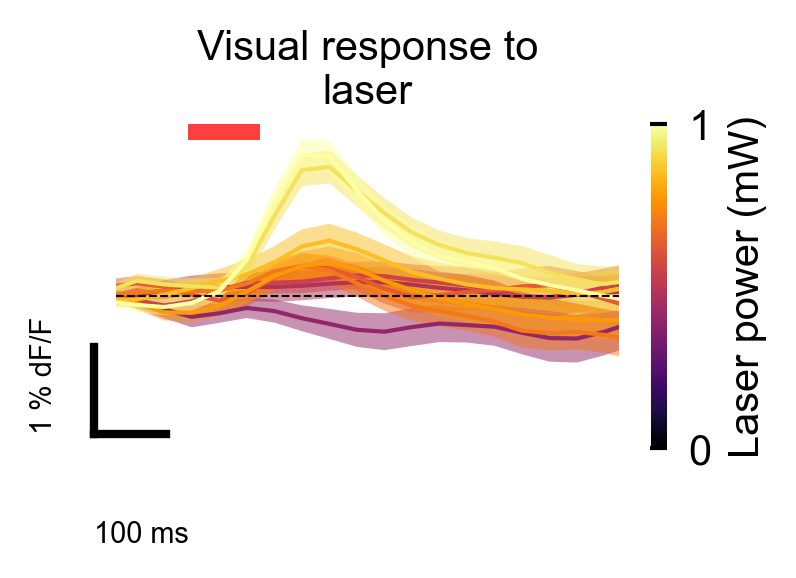

In [54]:
data=dataVis19
powers=np.unique(data.laserPowers)
galvoX=0;galvoY=0;x=120;y=380;width=1;anchor=(1,1)
ylim=[-0.01,0.008];start=-0.3;end=1;xlim=[-0.01,0.5]
t=1080
n_samples = round(start*-1+end)*35
colors=plt.cm.inferno(np.linspace(.4,1,len(powers)))
pxPowers = []
sems=[]
timestamps = np.linspace(start, end, n_samples)
galvoXTr=np.argwhere(data.galvoX[:t]==galvoX).ravel()
galvoYTr=np.argwhere(data.galvoY[:t]==galvoY).ravel()
loc=np.intersect1d(galvoXTr,galvoYTr)

y_range = np.arange(y - width, y + width)
x_range = np.arange(x - width, x + width)
# Create a meshgrid of the coordinates
y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
# Flatten the coordinate arrays
y_coords_flat = y_coords.flatten()
x_coords_flat = x_coords.flatten()
# Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

meanim = data.meanImage.reshape(560*560,-1)
meanroi = meanim[flat_indices]

for power in powers:
    pwTrs = np.argwhere(data.laserPowers[:t]== power).ravel()
    theseTrs=np.intersect1d(pwTrs,loc)
    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))

    trial_activity=[]
    for trial in trs:
        wf = data.tToWFManual(trial)
        mov = data.svdSpat[flat_indices] @ wf.T
        mov = mov + meanroi # adding back the mean from the session to get to true 'raw'
        mov_area_avg = np.mean(mov,axis=0) #avg over the 900 pixels
        mov_abs = mov_area_avg + np.abs(np.min(mov_area_avg))
        baseline_mean = np.mean(mov_abs[0:7])
        dff = (mov_abs - baseline_mean) / baseline_mean
        trial_activity.append(dff)
    pxPowers.append(np.mean(trial_activity,axis=0))
    sems.append(scipy.stats.sem(trial_activity,axis=0))

fig=plt.figure(figsize=(5,2),dpi=300)
gs = mpl.gridspec.GridSpec(1,2, figure=fig)
width_ratios = [1,1]
powerscorr = [round(i/2.777777778,2) for i in powers]
ax = plt.subplot(gs[0,0])
lines = [plt.plot(timestamps, y, label=f'{powerscorr[i]} mW',color=colors[i])[0] for i, y in enumerate(pxPowers)]

for iP, power in enumerate(pxPowers):
    plt.fill_between(timestamps, \
            power-sems[iP],\
            power+sems[iP], color=colors[iP],label='_nolegend_',alpha=.5,linewidth=0)

plt.axvspan(0,.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)

#set colorbar
cm = mpl.cm.ScalarMappable(cmap='inferno') # creates a color mapping object
cm.set_clim(0, 1) # sets limits to our power mW limits - exp.v_to_mw is 2.7 here
# plt.plot(x, y, c=cm.to_rgba(power/2.7), label=f'{power/2.7} mW') # the power variable is in V (taken from data npys)
cbar = plt.colorbar(ax=ax,mappable=cm,label='Laser power (mW)') # tells the colorbar to use your colormap object
cbar.set_ticks([0,1])
cbar.outline.set_visible(False)

#make scale bars
t_bar_s = 0.1 # length of time bar
dff_bar = 0.01 # length of dff bar
x_start = 0 - 0.13 # where the bar should start
y_start = -0.016 # where the bar should start

# plt.ylim([-.01,.03])
plt.xlim([-.1,0.6])
plt.axhline(0, color='k', linestyle='--',lw=0.5)
plt.plot([x_start, x_start+t_bar_s], [y_start, y_start], c='k', lw=2, clip_on=False) # these plot the bars
plt.plot([x_start, x_start], [y_start, y_start+dff_bar], c='k', lw=2, clip_on=False)
plt.text(x_start, y_start-0.01, f'{t_bar_s*1000:.0f} ms', ha='left', va='top', fontsize='x-small') # these are the text
plt.text(x_start-0.05, y_start, f'{dff_bar*100:.0f} % dF/F', ha='right', va='bottom', rotation=90, fontsize='x-small')
plt.title(f'Visual response to\nlaser')
plt.axvspan(0,0.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])
# fig.savefig('C:/Users/nadia/Documents/GitHub/steinmetzlab/wf + opto/log figs/AL35_119_new.png',dpi=300)

# can i add the datasets in the way that i want?